In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

In [2]:
mx.random.seed(1234)

### Set Context

In [3]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

### MNIST dataset

In [4]:
#Need to create this transform function because it is needed as and 
# argument for gluon.data.vision.MNIST
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)

mnist_train = gluon.data.vision.MNIST(train = True, transform=transform)
mnist_test = gluon.data.vision.MNIST(train = False, transform=transform)


In [5]:
#There are two parts of the dataset for training and testing. 
#Each part has N items and each item is a tuple of an image and a label:
image , label = mnist_train[0]
print(image.shape, label)

((28L, 28L, 1L), 5.0)


### Record the data and label shapes

In [26]:
num_inputs = 784
num_outputs = 10
num_examples = 60000

In [27]:
#Machine learning libraries generally expect to find images in 
#(batch, channel,height, width) format. 

#However, most libraries for visualization prefer (height,width, channel).
#Let’s transpose our image into the expected shape. 

im = mx.nd.tile(image,(1,1,3))
print(im.shape)


(28L, 28L, 3L)


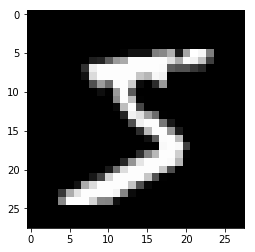

(10L,)

[ 3.  0.  4.  0.  7.  8.  5.  6.  1.  6.]
<NDArray 10 @cpu(0)>

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
<NDArray 10x10 @cpu(0)>


In [30]:
plt.imshow(im[:,:,:].asnumpy())
plt.show()
print(label.shape)
print(label)
print(nd.one_hot(label, 10))

### Load Data Iterator

In [9]:
batch_size = 64
train_data = mx.gluon.data.DataLoader(mnist_train,batch_size,shuffle = True)
test_data = mx.gluon.data.DataLoader(mnist_test,batch_size,shuffle = False)

### Allocate Model Parameters

In [10]:
W = nd.random_normal(shape = (num_inputs, num_outputs),ctx = model_ctx)
b = nd.random_normal(shape = num_outputs, ctx = model_ctx)

#This is the key part
params = [W,b]

for param in params:
    param.attach_grad()

### Create Multiclass Output via Softmax

In [11]:
#The basic modeling idea is that we’re going to linearly map our input X onto 
#10 different real valued outputs y_linear. Then, before outputting these values, 
#we’ll want to normalize them so that they are non-negative and sum to 1. 
#This normalization allows us to interpret the output ŷ  as a valid probability 
#distribution.

def softmax(y_linear):
    exp = nd.exp(y_linear - nd.max(y_linear,axis = 1).reshape((-1,1)))
    norms = nd.sum(exp, axis = 1).reshape((-1,1))
    return exp/norms

In [12]:
sample_y_linear = nd.random_normal(shape=(2,10))
sample_yhat = softmax(sample_y_linear)
print(sample_yhat)
print(nd.sum(sample_yhat,axis=1))


[[ 0.0591031   0.00812675  0.21637173  0.45503631  0.04909151  0.02593293
   0.01209063  0.0550333   0.02553189  0.09368184]
 [ 0.00868914  0.14350851  0.01133896  0.22071955  0.03680989  0.03792017
   0.05002966  0.01806846  0.45309511  0.01982054]]
<NDArray 2x10 @cpu(0)>

[ 1.  1.]
<NDArray 2 @cpu(0)>


### Define Net

In [13]:
def net(X):
    y_linear = nd.dot(X,W) + b
    yhat = softmax(y_linear)
    return yhat

### Define Multiclass LogLoss

In [14]:
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat+1e-6))

### Optimizer

In [15]:
#This is NOT SGD. It's implemented as Gradient Descent!
def SGD(params,lr):
    for param in params:
        param[:] = param - lr*param.grad

### Evaluate Accuracy

In [17]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()

In [18]:
#Because we initialized our model randomly, and because roughly 
#one tenth of all examples belong to each of the ten classes, we
#should have an accuracy in the ball park of .10.
evaluate_accuracy(test_data, net)

0.1169

### Execute Training Loop

In [21]:
epochs = 10
learning_rate = .005

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()


    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

Epoch 0. Loss: 0.397645657023, Train_acc 0.904133, Test_acc 0.8988
Epoch 1. Loss: 0.378962366633, Train_acc 0.9102, Test_acc 0.9031
Epoch 2. Loss: 0.365561845998, Train_acc 0.910117, Test_acc 0.9006
Epoch 3. Loss: 0.353258891078, Train_acc 0.913633, Test_acc 0.907
Epoch 4. Loss: 0.343561600928, Train_acc 0.91235, Test_acc 0.9044
Epoch 5. Loss: 0.335266771166, Train_acc 0.916567, Test_acc 0.9075
Epoch 6. Loss: 0.32844905076, Train_acc 0.919717, Test_acc 0.911
Epoch 7. Loss: 0.322126509194, Train_acc 0.916017, Test_acc 0.9091
Epoch 8. Loss: 0.316492702985, Train_acc 0.919883, Test_acc 0.9111
Epoch 9. Loss: 0.311113179396, Train_acc 0.918317, Test_acc 0.9078


### Predicting with the Trained Model

(10L, 28L, 28L, 1L)


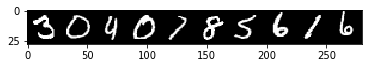

('model predictions are:', 
[ 3.  0.  4.  0.  2.  8.  5.  6.  1.  6.]
<NDArray 10 @cpu(0)>)


In [22]:
# Define the function to do prediction
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mnist_test, 10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break